## Fine-tuning Stable Diffusion XL with DreamBooth and LoRA

In this notebook, we'll see an example of how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora).

Note: SDXL consists of a much larger UNet and two text encoders that make the cross-attention context quite larger than the previous Stable Diffusion checkpoints.
So, in order to train on a T4 GPU, we'll need to make use of several tricks such as gradient checkpointing, mixed-precision, and 8-bit Adam. If these don't ring a bell, no worries at all! we'll walk through them all

## Setup 🪓

Create an account on the Hugging Face Hub 🤗 If you haven't done so yet, you can do so here: https://huggingface.co/join

In [1]:
# Check the GPU
!nvidia-smi

Tue Jun 18 15:01:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install dependencies.
!pip install bitsandbytes transformers accelerate peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 49.6 MB/s eta 0:00:00


Make sure to install `diffusers` from `main`.

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download diffusers SDXL DreamBooth training script.

In [4]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-06-18 15:03:32--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84303 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.33K  --.-KB/s    in 0.004s  

2024-06-18 15:03:32 (21.8 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84303/84303]



## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
pick option 1 or 2 below.



**Option 1:** upload example images from your local files:

In [5]:
import os
from google.colab import files

# pick a name for the image folder
local_dir = "./husky/" #@param
os.makedirs(local_dir)
os.chdir(local_dir)

# choose and upload local images into the newly created directory
uploaded_images = files.upload()
os.chdir("/content") # back to parent directory

Saving images (12).jpeg to images (12).jpeg
Saving images (11).jpeg to images (11).jpeg
Saving images (10).jpeg to images (10).jpeg
Saving images (9).jpeg to images (9).jpeg
Saving images (8).jpeg to images (8).jpeg
Saving images (7).jpeg to images (7).jpeg
Saving images (6).jpeg to images (6).jpeg
Saving images (5).jpeg to images (5).jpeg


Preview the images:

In [8]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

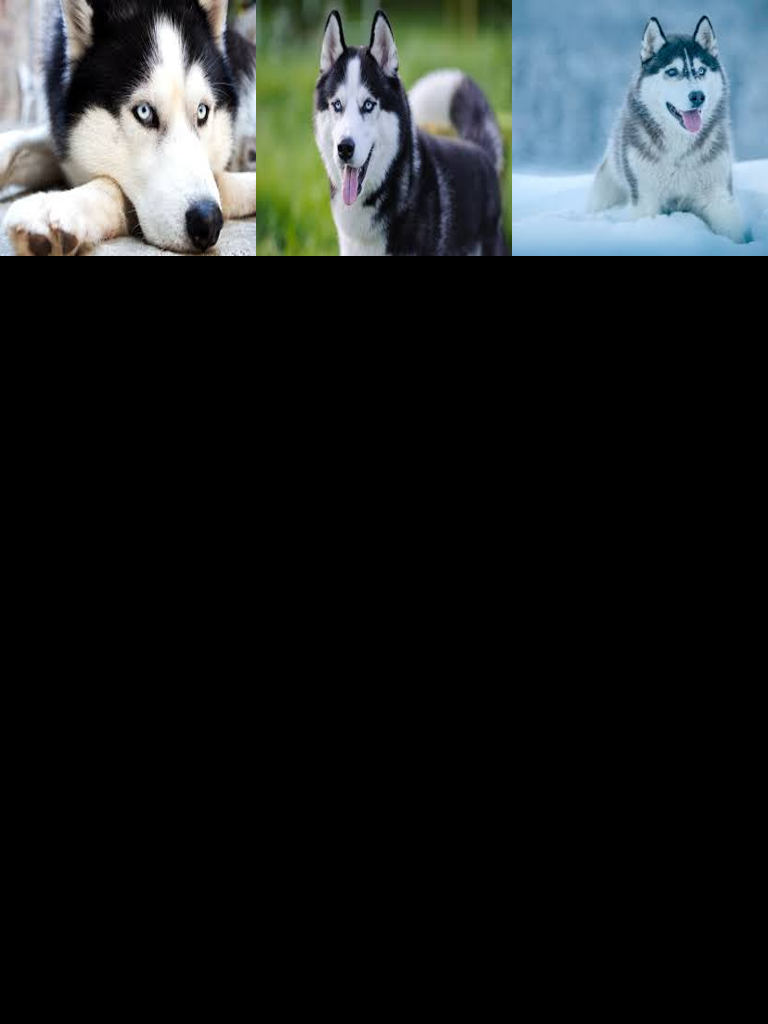

In [13]:
import glob

# change path to display images from your local dir
img_paths = "./husky/*.jpeg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 3

image_grid(imgs[:num_imgs_to_preview], 4, num_imgs_to_preview)

### Generate custom captions with BLIP
Load BLIP to auto caption your images:

In [ ]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

In [15]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./husky/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpeg")]

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.
Feel free to change the prefix according to the concept you're training on!
- for this example we can use "a photo of TOK," other options include:
    - For styles - "In the style of TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "a photo of TOK" we can use "a photo of TOK dog" / "a photo of TOK corgi dog"

In [16]:
import json

caption_prefix = "a photo of husky, " #@param
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

Free some memory:

In [17]:
import gc

# delete the BLIP pipelines and free up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [18]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [19]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

#### Set Hyperparameters ⚡
To ensure we can DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL, we're using:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

### Launch training 🚀🚀🚀

To allow for custom captions we need to install the `datasets` library, you can skip that if you want to train solely
 with `--instance_prompt`.
In that case, specify `--instance_data_dir` instead of `--dataset_name`

In [20]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is incompatible.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 16.1.0 which is incompatible.


 - Use `--output_dir` to specify your LoRA model repository name!
 - Use `--caption_column` to specify name of the cpation column in your dataset. In this example we used "prompt" to
 save our captions in the
 metadata file, change this according to your needs.

In [ ]:
!pip install --upgrade protobuf
!cp /usr/local/lib/python3.10/dist-packages/google/protobuf/internal/builder.py /content/
!pip install protobuf==3.19.6
!cp /content/builder.py /usr/local/lib/python3.10/dist-packages/google/protobuf/internal/

In [21]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="husky" \
  --output_dir="husky_lora" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="a photo of husky" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=300 \
  --checkpointing_steps=717 \
  --seed="0"

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-06-18 15:08:24.120531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 15:08:24.120597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 15:08:24.122371: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] 

### Save your model to the hub and check it out 🔥

In [22]:
from huggingface_hub import whoami
from pathlib import Path
#@markdown make sure the `output_dir` you specify here is the same as the one used for training
output_dir = "husky_lora" #@param
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [23]:
# @markdown Sometimes training finishes succesfuly (i.e. a **.safetensores** file with the LoRA weights saved properly to your local `output_dir`) but there's not enough RAM in the free tier to push the model to the hub 🙁
# @markdown
# @markdown To mitigate this, run this cell with your training arguments to make sure your model is uploaded! 🤗

# push to the hub🔥
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="a photo of bagan",
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",use_dora=True
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


events.out.tfevents.1718723486.3f63d95719f6.2755.1:   0%|          | 0.00/3.29k [00:00<?, ?B/s]

events.out.tfevents.1718723486.3f63d95719f6.2755.0:   0%|          | 0.00/66.6k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/YeBhoneLin10/husky_lora/commit/3af9d4ed62be90b52c4d33b935f66d558cf2fb85', commit_message='End of training', commit_description='', oid='3af9d4ed62be90b52c4d33b935f66d558cf2fb85', pr_url=None, pr_revision=None, pr_num=None)

In [24]:
from IPython.display import display, Markdown

link_to_model = f"https://huggingface.co/{repo_id}"
display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/YeBhoneLin10/husky_lora

Let's generate some images with it!

## Inference 🐕

In [25]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights("YeBhoneLin10/husky_lora")
_ = pipe.to("cuda")

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

pytorch_lora_weights.safetensors:   0%|          | 0.00/23.4M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

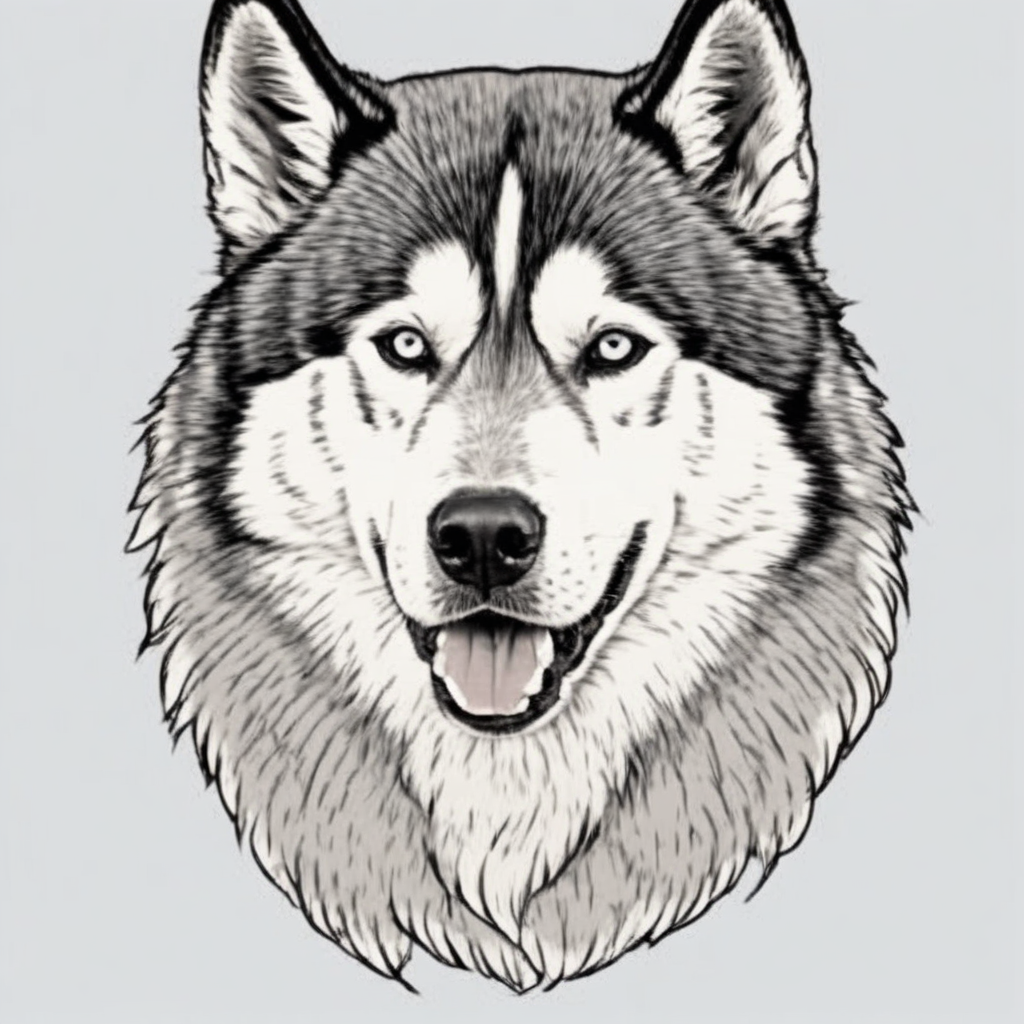

In [33]:
prompt = "(ISOLATED ON A PRISTINE WHITE BACKGROUND: 1.5), T-SHIRT DESIGN, VECTOR ART, CONTOUR, Sad husky with a white background." # @param

image = pipe(prompt=prompt, num_inference_steps=50).images[0]
image

### Translation

In [ ]:
!pip install -U deep-translator

In [ ]:
from deep_translator import GoogleTranslator

translate = GoogleTranslator(source='my', target='en') # the source = myanmar, target = english
prompt = "husky ‌ပျော်ရွှင်နေသော" # @param
myanmar_text_to_eng = translate.translate(prompt)
num_inference_steps = 10 # @param
guidance_scale = 0.7 # @param
negative_prompt = "ပုံထပ်တာ" # @param
myanmar_text_to_eng_negative = translate.translate(negative_prompt)

image = pipe(prompt=myanmar_text_to_eng, num_inference_steps=num_inference_steps,guidance_scale=guidance_scale,negative_prompt=myanmar_text_to_eng_negative).images[0]
image

### Deployment

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import torch
from diffusers import DiffusionPipeline, AutoencoderKL
import gradio as gr

g_cuda = torch.Generator(device='cuda')


def inference(prompt, negative_prompt,num_inference_steps,guidance_scale):
    image = pipe(prompt, negative_prompt=negative_prompt, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale).images[0]
    return [image]

def add(prompt, medium,style,website,resolution,lighting):
    return f'{prompt}, {medium}, {style},{website}, {resolution}, {lighting}'

with gr.Blocks() as demo:
    with gr.Row():
      medium = gr.Dropdown(['digital painting', 'photography', 'oil painting', 'portrait', 'concept art', 'underwater portrait', 'underwater steampunk'], label="Medium", value="concept art")
      style = gr.Dropdown(['hyperrealistic', 'pop-art', 'modernist', 'art nouveau'], label="Style", value='modernist')
      website = gr.Dropdown(['pixiv', 'pixabay', 'artstation'], label="Website", value="artstation")
      resolution = gr.Dropdown(['unreal engine', 'sharp focus', 'vray'], label="Resolution", value="vray")
      lighting = gr.Dropdown(['rim lighting', 'cinematic lighting', 'crepuscular rays'], label="Lighting", value="cinematic lighting")

      with gr.Column():
          prompt = gr.Textbox(label="Additional Details", value="Establishing shot of a bagan, an epic fantasy, dramatic lighting, cinematic, extremely high detail, photorealistic, cinematic lighting, matte painting, artstation, by simon stalenhag, uncharted 4: a thief's end")
          run = gr.Button(value="Generate Prompt")

    with gr.Row():
        with gr.Column():
          prompt2 = gr.Textbox(label="Prompt",value="Establishing shot of a bagan, an epic fantasy, dramatic lighting, cinematic, extremely high detail, photorealistic, cinematic lighting, matte painting, artstation, by simon stalenhag, uncharted 4: a thief's end")
          run.click(add, inputs=[prompt, medium, style, website, resolution, lighting], outputs=[prompt2])
          negative_prompt = gr.Textbox(label='Negative Prompt',value="watermark, amputee, autograph, bad anatomy, bad illustration,  bad proportions, beyond the borders, blank background, blurry, body out of frame, boring background, branding cropped cut off, deformed, disfigured, dismembered")

        with gr.Row():
          guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
          num_inference = gr.Number(label='Inference Steps',value=10)

    with gr.Column():
      run = gr.Button(value="Generate")
    with gr.Column():
        gallery = gr.Gallery()
    run.click(inference, inputs=[prompt2, negative_prompt, num_inference, guidance_scale], outputs=gallery)

demo.launch(debug=True, share=True)